# Fully connected Auto-Encoder for Tabular Data
In order to compare the classical and quantum methods we will implement several methods including the deep learning method, fully connected auto-encoder. 

### Imports

In [471]:
# Data processing
import pandas as pd
import numpy as np
from collections import Counter
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Sets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix, precision_recall_curve


#Auto-encoder imports
import torchvision
from torchvision import datasets
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import bctools as bc

#DataSets that we can test
vowel = 'https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/vowel/vowel-context.data'
iris = load_iris()
breast_cancer = load_breast_cancer()

name_datasets_sklearn = {'iris_data': iris, 'breast_cancer_data': breast_cancer}

# TODO: some error because of the location of the file
# from ipynb.fs.full.EDA import vowelData
# from ipynb.fs.full.EDA import irisData
# from ipynb.fs.full.EDA import breastcancerData

In [472]:
import warnings
warnings.filterwarnings("ignore")

### Load data

In [473]:
vowel_data = pd.read_csv(vowel, index_col=False, delim_whitespace=True, header=None)
iris_data = pd.DataFrame(np.concatenate((name_datasets_sklearn["iris_data"]["data"], name_datasets_sklearn["iris_data"]["target"].reshape(-1,1)), axis=1))
breast_cancer_data = pd.DataFrame(np.concatenate((name_datasets_sklearn["breast_cancer_data"]["data"], name_datasets_sklearn["breast_cancer_data"]["target"].reshape(-1,1)), axis=1))
datasets = [vowel_data, iris_data, breast_cancer_data]

In [474]:
def get_dataloaders(dataset, normal_classes, anomaly_classes, batch_size=64, normal_test_percentage=0.1, seed=42):
    normal_data = dataset.copy()
    anomaly_data = dataset.copy()

    normal_data.iloc[:,:-1] = (normal_data.iloc[:,:-1] - normal_data.iloc[:,:-1].mean()) / normal_data.iloc[:,:-1].std()
    anomaly_data.iloc[:,:-1] = (anomaly_data.iloc[:,:-1] - anomaly_data.iloc[:,:-1].mean()) / anomaly_data.iloc[:,:-1].std()

    # isolate normal classes
    normal_data = normal_data[normal_data.iloc[:,-1].isin(normal_classes)].to_numpy()
    normal_data[:,-1] = 0

    # isolate anomaly classes
    anomaly_data = anomaly_data[anomaly_data.iloc[:,-1].isin(anomaly_classes)].to_numpy()
    anomaly_data[:,-1] = 1

    # split the data into train and test with the `normal_test_percentage` of the normal data being in the test set
    # together with all of the anomalies
    len_normal = normal_data.shape[0]
    train_size = int(len_normal * (1-normal_test_percentage))
    test_normal_size = len_normal - train_size

    train_data, test_data = torch.utils.data.random_split(normal_data, [train_size, test_normal_size], generator=torch.Generator().manual_seed(seed))
    test_data = np.concatenate([test_data, anomaly_data])

    train_data = np.array(train_data, dtype=np.float32)
    test_data = np.array(test_data, dtype=np.float32)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
    
    return train_loader, test_loader

### Autoencoder

In [475]:
# Define the autoencoder class
class AutoEncoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Linear(hidden_size//2, hidden_size//4)
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size//4, hidden_size//2),
            nn.ReLU(),
            nn.Linear(hidden_size//2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def train(self, train_loader, normal_classes, anomaly_classes, n_epochs=50, criterion=nn.MSELoss()):
        optimizer = optim.Adam(self.parameters(), lr=0.005)

        for epoch in range(n_epochs):
            for batch in train_loader:

                X = batch[:, :-1] # drop the label

                # Forward pass
                output = self(X)
                loss = criterion(output, X)
                
                # Backward pass and optimization step
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
                
            # Print the loss for this epoch
            print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}")

    def get_reconstruction_errors(self, loader):
        diffs = np.array([])
        all_labels = np.array([])
        for data in loader:
            labels = data[:,-1]
            data = data[:,:-1]
            rec_data = self(data)
            rec_error = torch.sum((data - rec_data)**2, axis=1)
            diffs = np.concatenate((diffs, rec_error.detach().numpy()))
            all_labels = np.concatenate((all_labels, labels.detach().numpy()))
        return diffs, all_labels

    def classify(self, loader, threshold):
        errors, labels = self.get_reconstruction_errors(loader)
        preds = np.where(errors > threshold, 1, 0)
        return preds, labels

In [476]:
# data = vowel_data
# model = AutoEncoder(data.shape[1]-1, 12)
# train_loader, test_loader = get_dataloaders(data, [0,1], [2,3])
# model.train(train_loader, [0], [8])
# errors, labels = model.get_reconstruction_errors(test_loader)
# np.mean(errors[labels==0]), np.mean(errors[labels==1])

In [477]:
# model.classify(test_loader, 4.5)

In [478]:
def accuracy_score(preds, labels):
    return np.sum(preds == labels)/len(preds)

def precision_score(preds, labels):
    tp = np.sum((preds == 1) & (labels == 1))
    fp = np.sum((preds == 1) & (labels == 0))
    return tp/(tp + fp)

def recall_score(preds, labels):
    tp = np.sum((preds == 1) & (labels == 1))
    fn = np.sum((preds == 0) & (labels == 1))
    return tp/(tp + fn)

def f1_score(preds, labels):
    prec = precision_score(preds, labels)
    rec = recall_score(preds, labels)
    return 2 * prec * rec / (prec + rec)

def statistics(preds, labels):
    return {
        "accuracy": accuracy_score(preds, labels),
        "precision": precision_score(preds, labels),
        "recall": recall_score(preds, labels),
        "f1": f1_score(preds, labels)
    }

def plot_distribution_reconstruction(errors, labels, title="Reconstruction error distribution"):
    normal_mean, anomaly_mean = np.mean(errors[labels==0]), np.mean(errors[labels==1])
    sns.kdeplot(errors[labels==0], shade=True, label=f"Normal (mean={normal_mean})", clip=[0, np.inf])
    sns.kdeplot(errors[labels==1], shade=True, label=f"Anomaly (mean={anomaly_mean})", clip=[0, np.inf])
    plt.legend()
    plt.xlabel("Reconstruction error")
    plt.ylabel("Density")
    plt.title(title)
    plt.show()

def print_statistics(preds, labels):
    stats = statistics(preds, labels)
    print("Accuracy:", stats["accuracy"])
    print("Precision:", stats["precision"])
    print("Recall:", stats["recall"])
    print("F1:", stats["f1"])    

def plot_confusion_matrix(preds, labels):
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt='g', cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

def get_thresholds_from_predictions(model, dataloader):
    errors, _ = model.get_reconstruction_errors(dataloader)
    return get_thresholds_in_range(np.min(errors), np.max(errors), 100)

def get_thresholds_in_range(min, max, num):
    return np.linspace(min, max, num)

def j_statistic(preds, labels):
    tp = np.sum((preds == 1) & (labels == 1))
    fp = np.sum((preds == 1) & (labels == 0))
    fn = np.sum((preds == 0) & (labels == 1))
    tn = np.sum((preds == 0) & (labels == 0))
    return tp/(tp + fn) + tn/(tn + fp) - 1

def select_threshold(model, dataloader):
    thresholds = get_thresholds_from_predictions(model, dataloader)
    best_threshold = None
    best_j_stat = -1
    for threshold in thresholds:
        preds, labels = model.classify(dataloader, threshold)
        j_stat = j_statistic(preds, labels)
        if j_stat > best_j_stat:
            best_j_stat = j_stat
            best_threshold = threshold
    return best_threshold

def plot_roc_curve(model, dataloader, thresholds, optimal_threshold=True):
    fpr = []
    tpr = []
    for threshold in thresholds:
        preds, labels = model.classify(dataloader, threshold)
        fpr.append(1 - recall_score(preds, labels))
        tpr.append(precision_score(preds, labels))
    plt.plot([0,*fpr,1], [0, *tpr, 1], label="Model")
    plt.plot([0, 1], [0, 1], linestyle='--', label="Baseline")
    if optimal_threshold:
        opt_threshold = select_threshold(model, dataloader)
        preds, labels = model.classify(dataloader, opt_threshold)
        plt.plot(1 - recall_score(preds, labels), precision_score(preds, labels), marker='o', label="Optimal threshold (t={:.2f})".format(opt_threshold))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

def plot_precision_recall_curve(model, dataloader, thresholds):
    precisions = []
    recalls = []
    for threshold in thresholds:
        preds, labels = model.classify(dataloader, threshold)
        precisions.append(precision_score(preds, labels))
        recalls.append(recall_score(preds, labels))
    plt.plot([1, *recalls, 0], [0, *precisions, 1])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.show()

def fancy_confusion_plot(preds, labels):
    cf_fig, var_metrics_df, invar_metrics_df, opt_thresh_df = bc.confusion_matrix_plot(
    true_y = labels, 
    predicted_proba = preds, 
    threshold_step = 0.05, 
    title = 'Interactive Confusion Matrix for the Test Set')
    cf_fig.show()

In [479]:
# print_statistics(*model.classify(test_loader, 4.5))

In [480]:
# thresholds = get_thresholds_from_predictions(model, test_loader)
# plot_precision_recall_curve(model, test_loader, thresholds)
# plot_roc_curve(model, test_loader, thresholds)

In [481]:
# plot_confusion_matrix(*model.classify(test_loader, 4.5))

In [482]:
# plot_distribution_reconstruction(*model.get_reconstruction_errors(test_loader))

# Combined pipeline

In [483]:
def everything(data, normal_classes, anomaly_classes, normal_test_percentage=0.2):
    model = AutoEncoder(data.shape[1]-1, 12)
    train_loader, test_loader = get_dataloaders(data, normal_classes, anomaly_classes, normal_test_percentage=normal_test_percentage)
    model.train(train_loader, normal_classes, anomaly_classes)
    errors, labels = model.get_reconstruction_errors(test_loader)
    opt_threshold = select_threshold(model, test_loader)
    print("Optimal threshold:", opt_threshold)
    preds, labels = model.classify(test_loader, opt_threshold)
    print_statistics(preds, labels)
    plot_confusion_matrix(*model.classify(test_loader, opt_threshold))
    plot_distribution_reconstruction(*model.get_reconstruction_errors(train_loader), "Train")
    plot_distribution_reconstruction(*model.get_reconstruction_errors(test_loader), "Test")
    thresholds = get_thresholds_from_predictions(model, test_loader)
    plot_precision_recall_curve(model, test_loader, thresholds)
    plot_roc_curve(model, test_loader, thresholds)

## Iris dataset

Epoch [1/50], Loss: 1.1487
Epoch [2/50], Loss: 1.1010
Epoch [3/50], Loss: 1.0573
Epoch [4/50], Loss: 1.0171
Epoch [5/50], Loss: 0.9793
Epoch [6/50], Loss: 0.9437
Epoch [7/50], Loss: 0.9105
Epoch [8/50], Loss: 0.8861
Epoch [9/50], Loss: 0.8638
Epoch [10/50], Loss: 0.8416
Epoch [11/50], Loss: 0.8179
Epoch [12/50], Loss: 0.7924
Epoch [13/50], Loss: 0.7648
Epoch [14/50], Loss: 0.7348
Epoch [15/50], Loss: 0.7012
Epoch [16/50], Loss: 0.6644
Epoch [17/50], Loss: 0.6250
Epoch [18/50], Loss: 0.5850
Epoch [19/50], Loss: 0.5492
Epoch [20/50], Loss: 0.5232
Epoch [21/50], Loss: 0.5113
Epoch [22/50], Loss: 0.5074
Epoch [23/50], Loss: 0.4960
Epoch [24/50], Loss: 0.4728
Epoch [25/50], Loss: 0.4489
Epoch [26/50], Loss: 0.4318
Epoch [27/50], Loss: 0.4225
Epoch [28/50], Loss: 0.4127
Epoch [29/50], Loss: 0.3980
Epoch [30/50], Loss: 0.3839
Epoch [31/50], Loss: 0.3731
Epoch [32/50], Loss: 0.3653
Epoch [33/50], Loss: 0.3578
Epoch [34/50], Loss: 0.3495
Epoch [35/50], Loss: 0.3426
Epoch [36/50], Loss: 0.3371
E

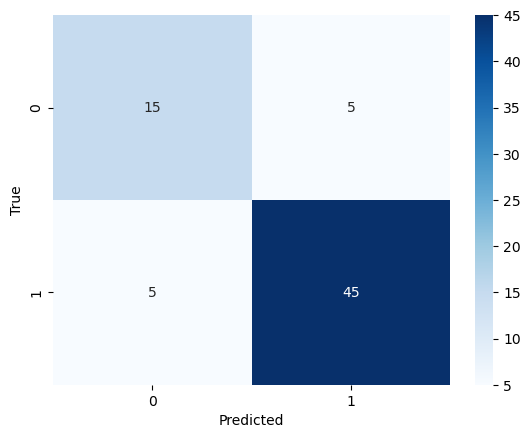

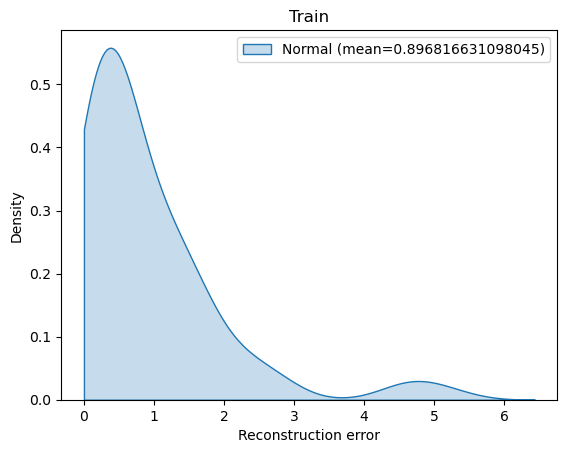

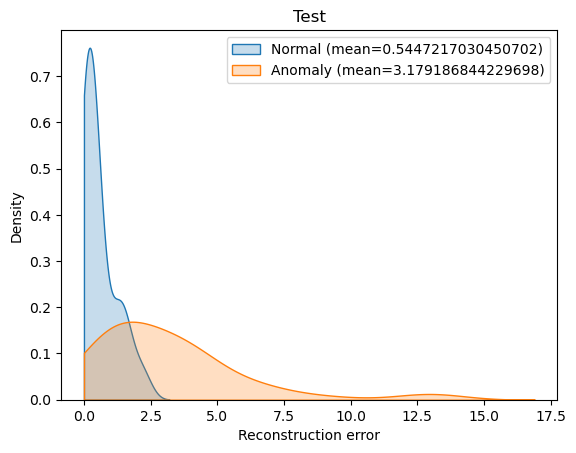

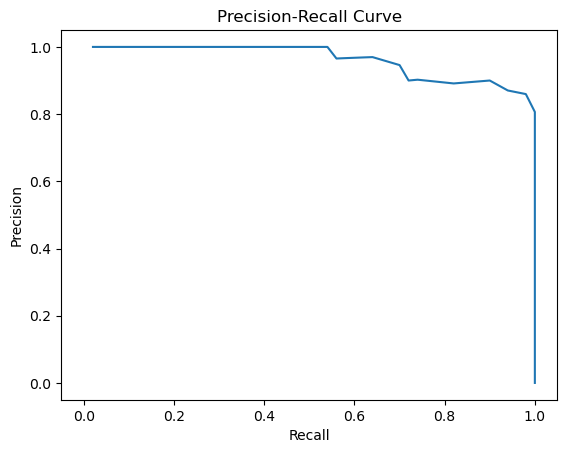

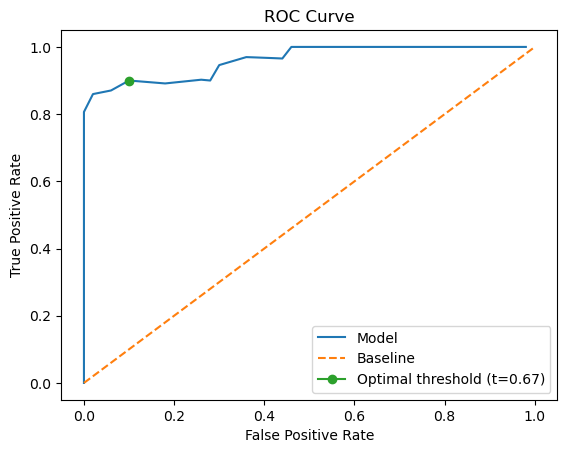

In [491]:
everything(data = iris_data, 
           normal_classes = [0,1],
           anomaly_classes = [2])

### Breast cancer dataset

Epoch [1/50], Loss: 1.6622
Epoch [2/50], Loss: 1.6068
Epoch [3/50], Loss: 1.5533
Epoch [4/50], Loss: 1.5008
Epoch [5/50], Loss: 1.4454
Epoch [6/50], Loss: 1.3815
Epoch [7/50], Loss: 1.3023
Epoch [8/50], Loss: 1.2010
Epoch [9/50], Loss: 1.0813
Epoch [10/50], Loss: 0.9871
Epoch [11/50], Loss: 0.9414
Epoch [12/50], Loss: 0.8729
Epoch [13/50], Loss: 0.8273
Epoch [14/50], Loss: 0.7958
Epoch [15/50], Loss: 0.7565
Epoch [16/50], Loss: 0.7295
Epoch [17/50], Loss: 0.7123
Epoch [18/50], Loss: 0.6909
Epoch [19/50], Loss: 0.6787
Epoch [20/50], Loss: 0.6653
Epoch [21/50], Loss: 0.6568
Epoch [22/50], Loss: 0.6465
Epoch [23/50], Loss: 0.6382
Epoch [24/50], Loss: 0.6287
Epoch [25/50], Loss: 0.6183
Epoch [26/50], Loss: 0.6071
Epoch [27/50], Loss: 0.5929
Epoch [28/50], Loss: 0.5783
Epoch [29/50], Loss: 0.5626
Epoch [30/50], Loss: 0.5461
Epoch [31/50], Loss: 0.5282
Epoch [32/50], Loss: 0.5100
Epoch [33/50], Loss: 0.4948
Epoch [34/50], Loss: 0.4823
Epoch [35/50], Loss: 0.4711
Epoch [36/50], Loss: 0.4618
E

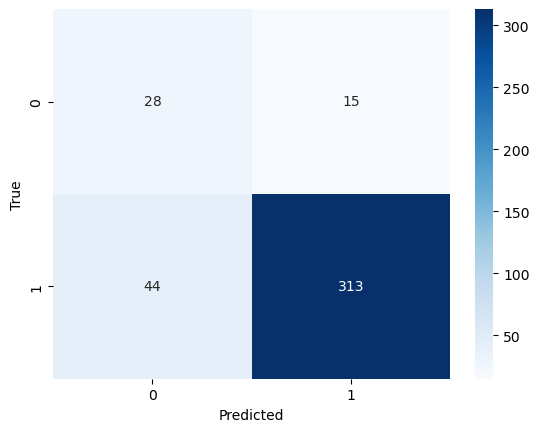

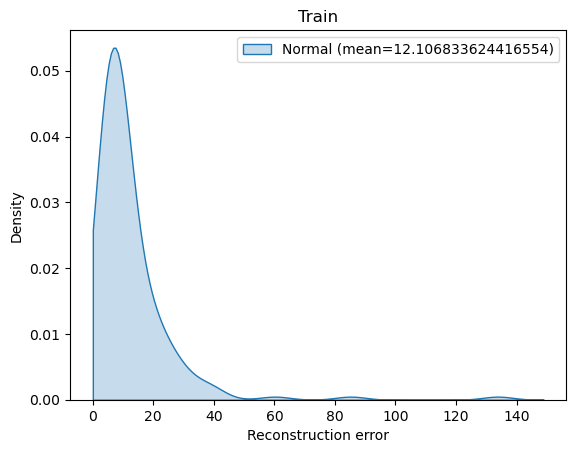

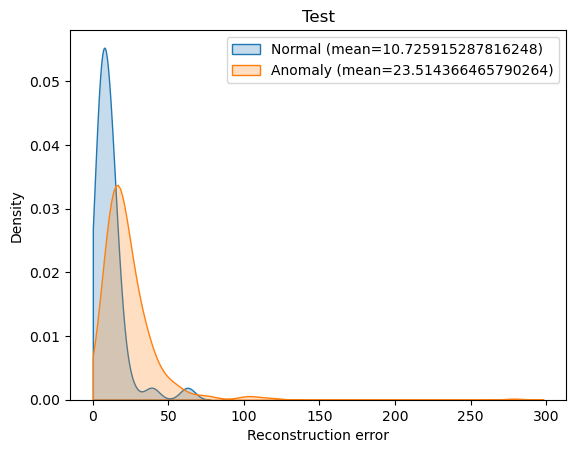

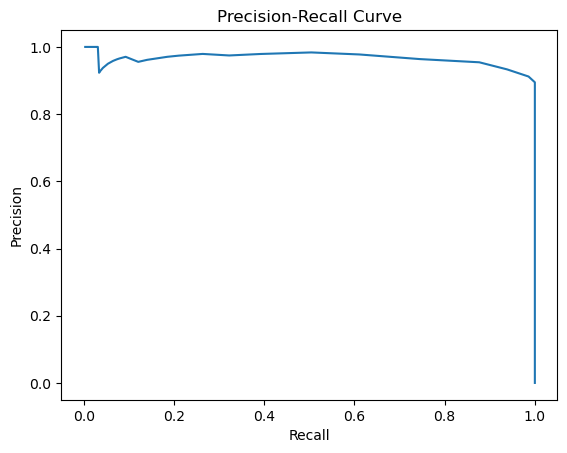

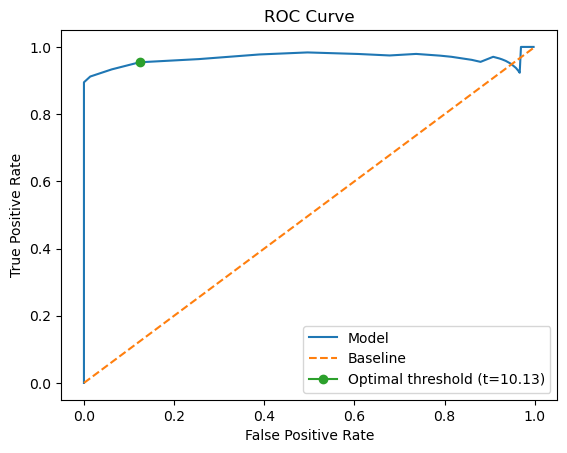

In [487]:
everything(data = breast_cancer_data, 
           normal_classes = [0],
           anomaly_classes = [1])

### Vowel Dataset

Epoch [1/50], Loss: 1.4946
Epoch [2/50], Loss: 1.4623
Epoch [3/50], Loss: 1.4321
Epoch [4/50], Loss: 1.4042
Epoch [5/50], Loss: 1.3787
Epoch [6/50], Loss: 1.3556
Epoch [7/50], Loss: 1.3347
Epoch [8/50], Loss: 1.3160
Epoch [9/50], Loss: 1.2992
Epoch [10/50], Loss: 1.2842
Epoch [11/50], Loss: 1.2711
Epoch [12/50], Loss: 1.2596
Epoch [13/50], Loss: 1.2497
Epoch [14/50], Loss: 1.2414
Epoch [15/50], Loss: 1.2345
Epoch [16/50], Loss: 1.2289
Epoch [17/50], Loss: 1.2245
Epoch [18/50], Loss: 1.2210
Epoch [19/50], Loss: 1.2183
Epoch [20/50], Loss: 1.2163
Epoch [21/50], Loss: 1.2148
Epoch [22/50], Loss: 1.2137
Epoch [23/50], Loss: 1.2130
Epoch [24/50], Loss: 1.2126
Epoch [25/50], Loss: 1.2124
Epoch [26/50], Loss: 1.2124
Epoch [27/50], Loss: 1.2126
Epoch [28/50], Loss: 1.2128
Epoch [29/50], Loss: 1.2130
Epoch [30/50], Loss: 1.2133
Epoch [31/50], Loss: 1.2135
Epoch [32/50], Loss: 1.2137
Epoch [33/50], Loss: 1.2138
Epoch [34/50], Loss: 1.2139
Epoch [35/50], Loss: 1.2140
Epoch [36/50], Loss: 1.2140
E

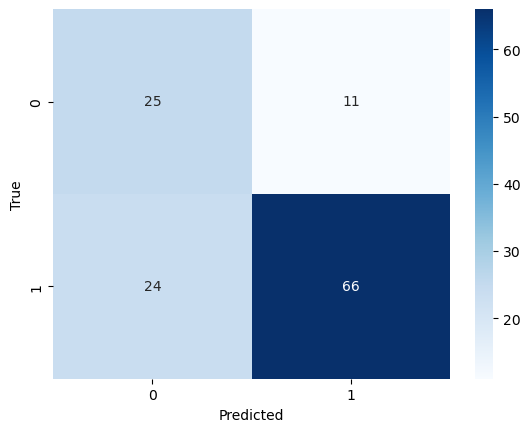

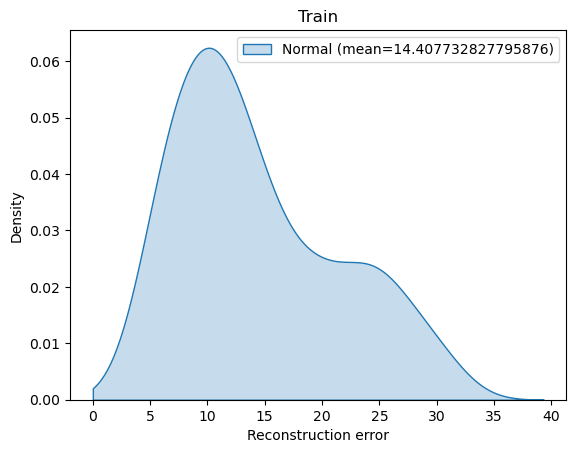

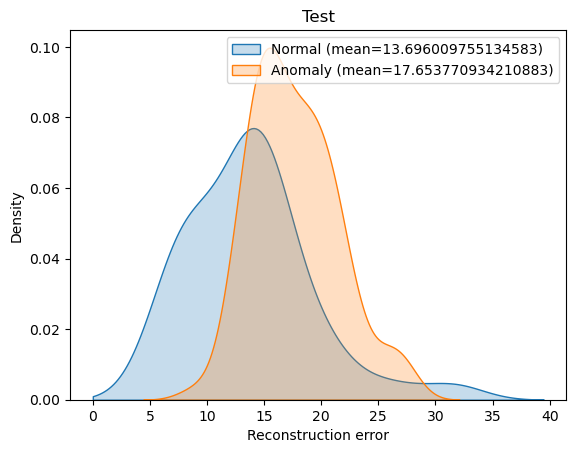

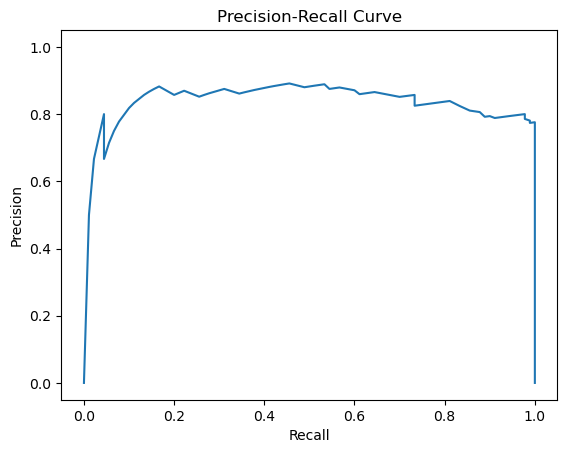

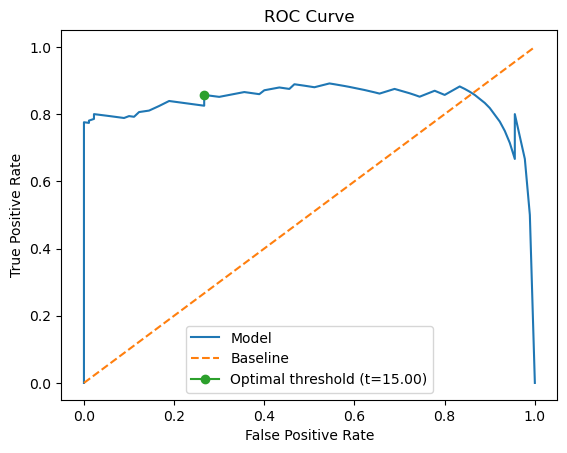

In [488]:
everything(data = vowel_data,
           normal_classes = [0,1],
           anomaly_classes = [8])